# Error Analysis for Image Classification
## Data Science at [Zindua School](https://zinduaschool.com)
### Notes by [Cyril Michino](https://cyril.michino.co.ke)

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid ##For building the image grid
warnings.filterwarnings('once')
%matplotlib inline

In [3]:
from sklearn.datasets import load_digits
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Data Exploration

### Data Sourcing & Summary
We'll use the `load_digits` toy dataset from Scikit Learn. Here is the [documentation for the data](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset). This data was originally sourced from [UCI ML Repository](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits)

Note that while this data is image data, the extraction of features has already been executed from the data source using NIST preprocessing routines. For info on these routines, see **M. D. Garris, J. L. Blue, G. T. Candela, D. L. Dimmick, J. Geist, P. J. Grother, S. A. Janet, and C. L. Wilson, NIST Form-Based Handprint Recognition System, NISTIR 5469, 1994.**

In [4]:
digits = load_digits()
images = digits.images
print(images.shape)

(1797, 8, 8)


In [5]:
## Combine the features and label into one dataframe for easier analysis
data = pd.DataFrame(digits.data, columns=digits.feature_names)
data['digit'] = digits.target
data.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,digit
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1797 non-null   float64
 1   pixel_0_1  1797 non-null   float64
 2   pixel_0_2  1797 non-null   float64
 3   pixel_0_3  1797 non-null   float64
 4   pixel_0_4  1797 non-null   float64
 5   pixel_0_5  1797 non-null   float64
 6   pixel_0_6  1797 non-null   float64
 7   pixel_0_7  1797 non-null   float64
 8   pixel_1_0  1797 non-null   float64
 9   pixel_1_1  1797 non-null   float64
 10  pixel_1_2  1797 non-null   float64
 11  pixel_1_3  1797 non-null   float64
 12  pixel_1_4  1797 non-null   float64
 13  pixel_1_5  1797 non-null   float64
 14  pixel_1_6  1797 non-null   float64
 15  pixel_1_7  1797 non-null   float64
 16  pixel_2_0  1797 non-null   float64
 17  pixel_2_1  1797 non-null   float64
 18  pixel_2_2  1797 non-null   float64
 19  pixel_2_3  1797 non-null   float64
 20  pixel_2_

In [7]:
data.describe()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,digit
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


No missing values in the data, images were preprocessed into 64 features representing the pixels of every image in an 8 by 8 grid. All pixel data is a float number ranging from 0 to 16. **No cleaning needed for the data.**

### Data Visualisation

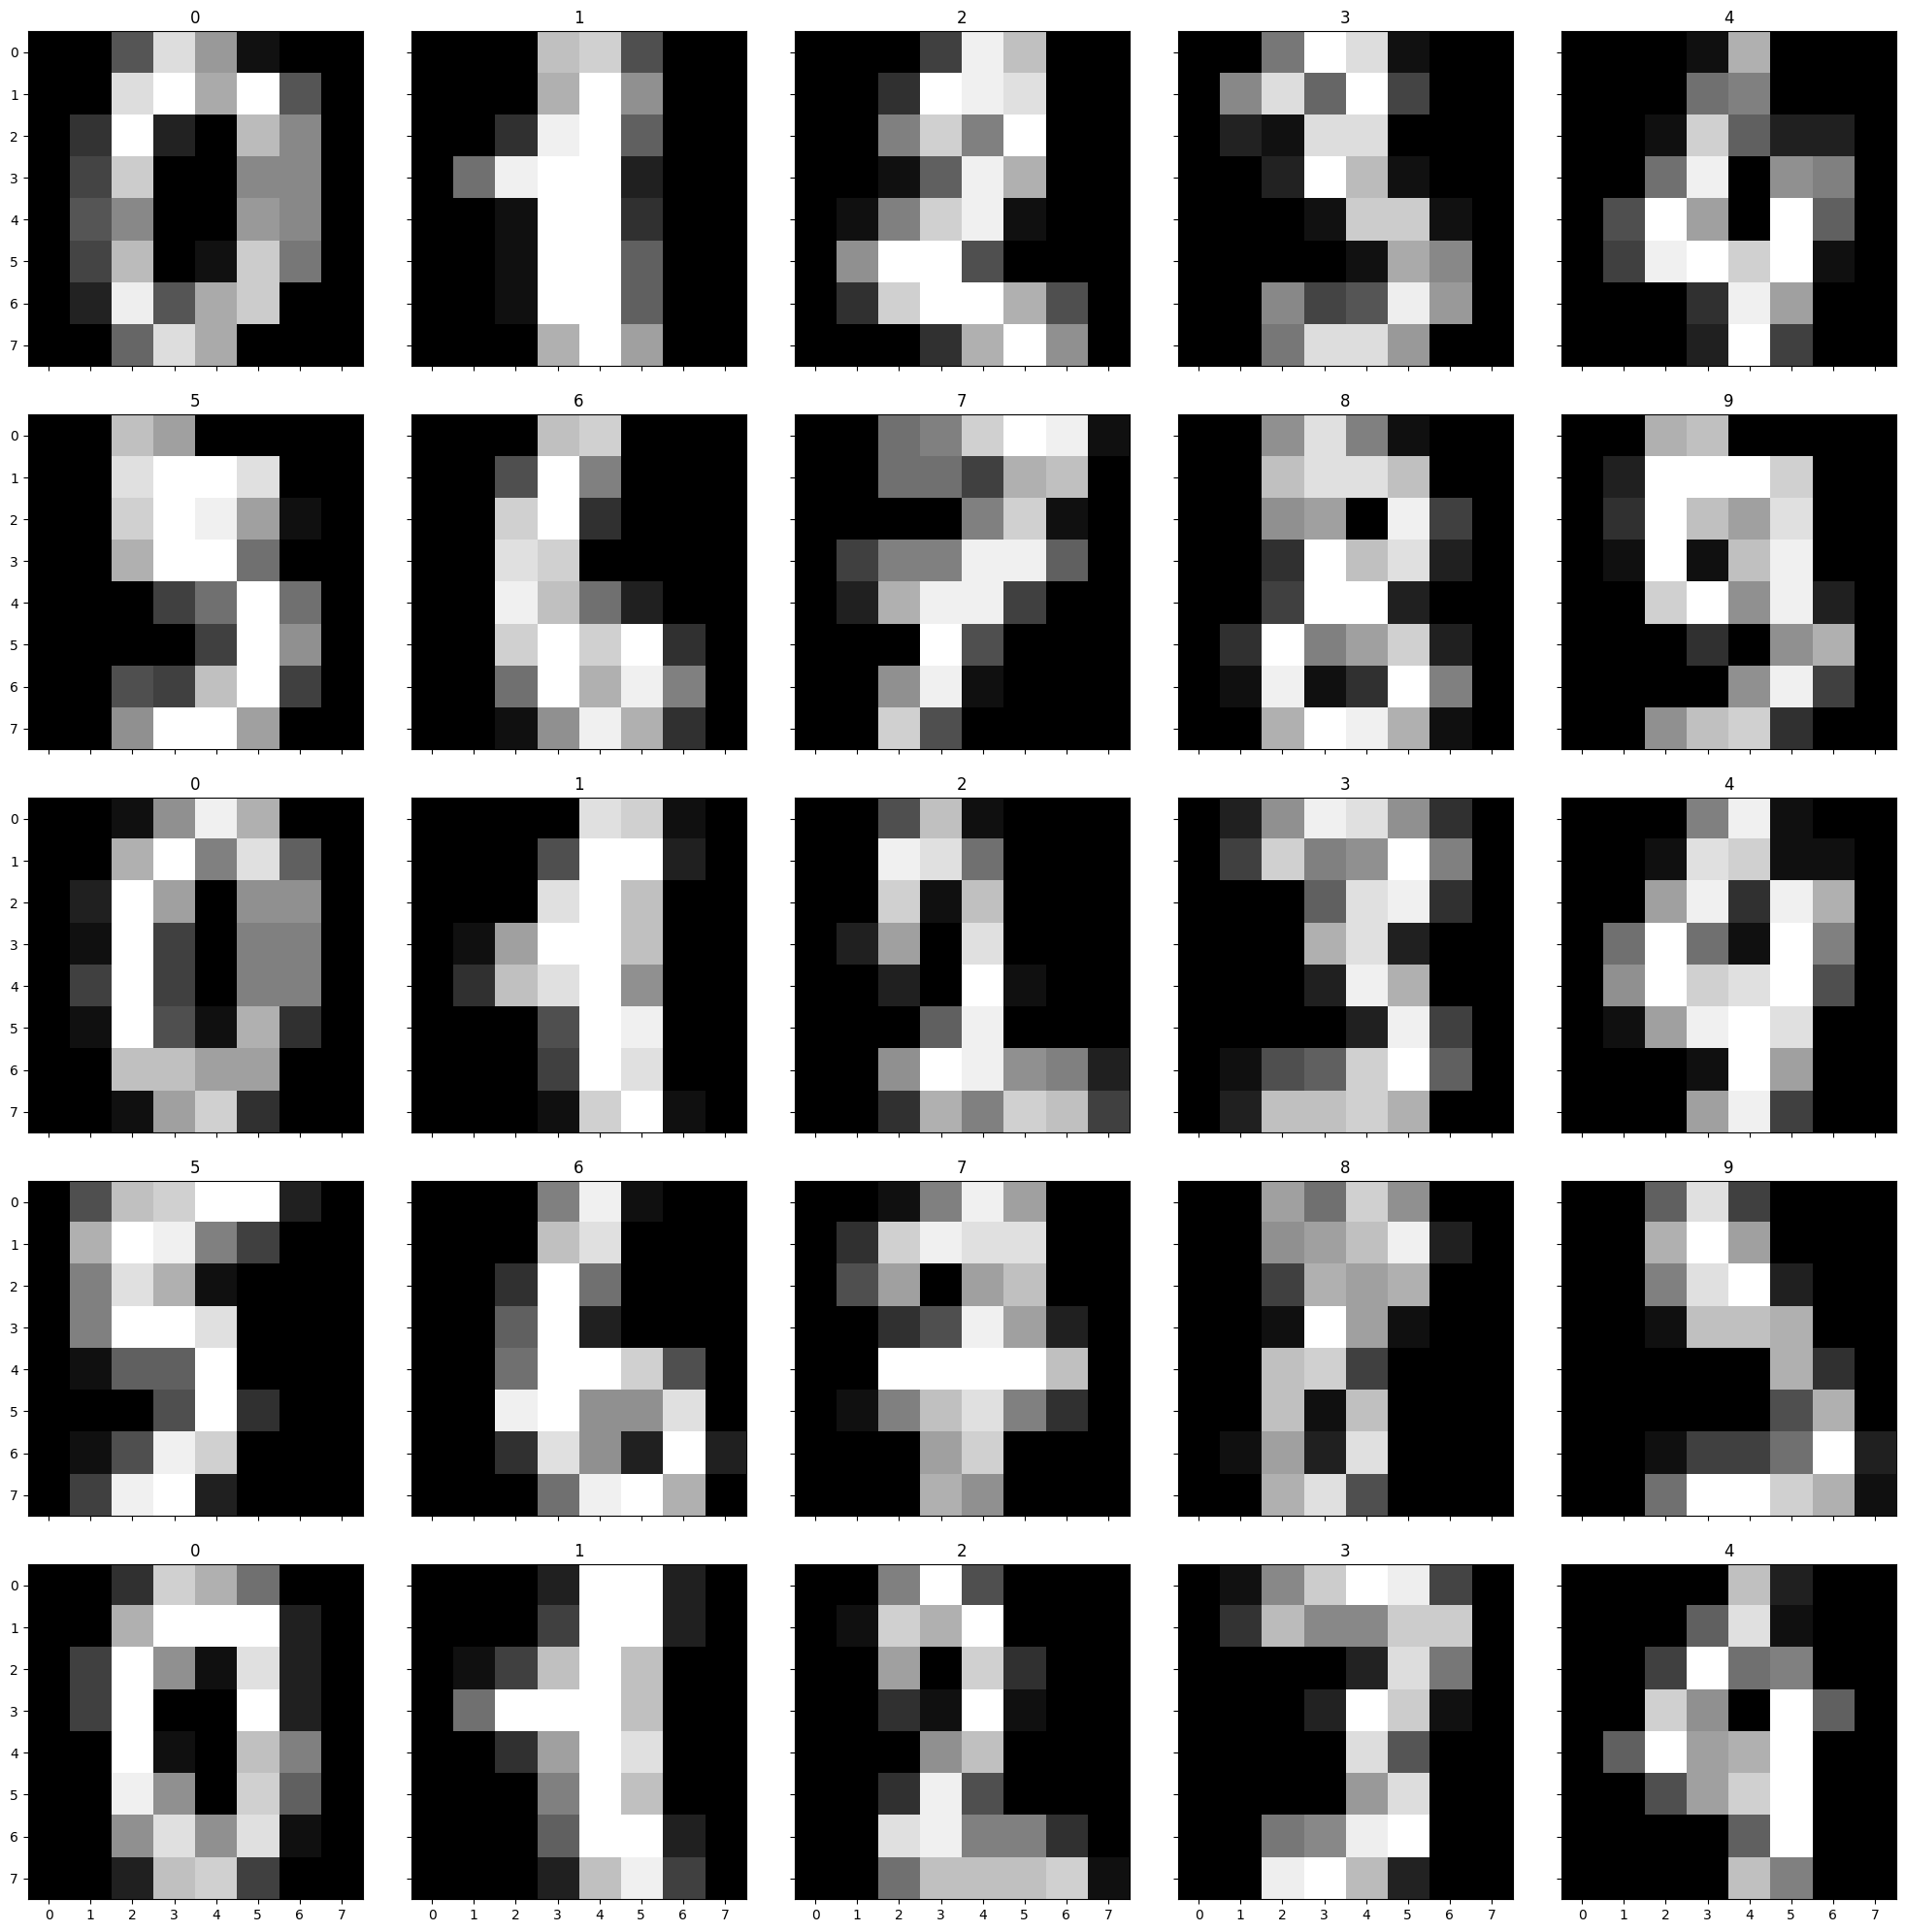

In [8]:
##Visualising the images from the pixel data
fig = plt.figure(figsize=(25, 25))
grid = ImageGrid(fig, 111,  nrows_ncols=(5, 5), axes_pad=0.5)

for ax, image, label in zip(grid, images[:25], data.digit[:25]):
    ax.imshow(image, cmap='gray')
    ax.set_title(label)

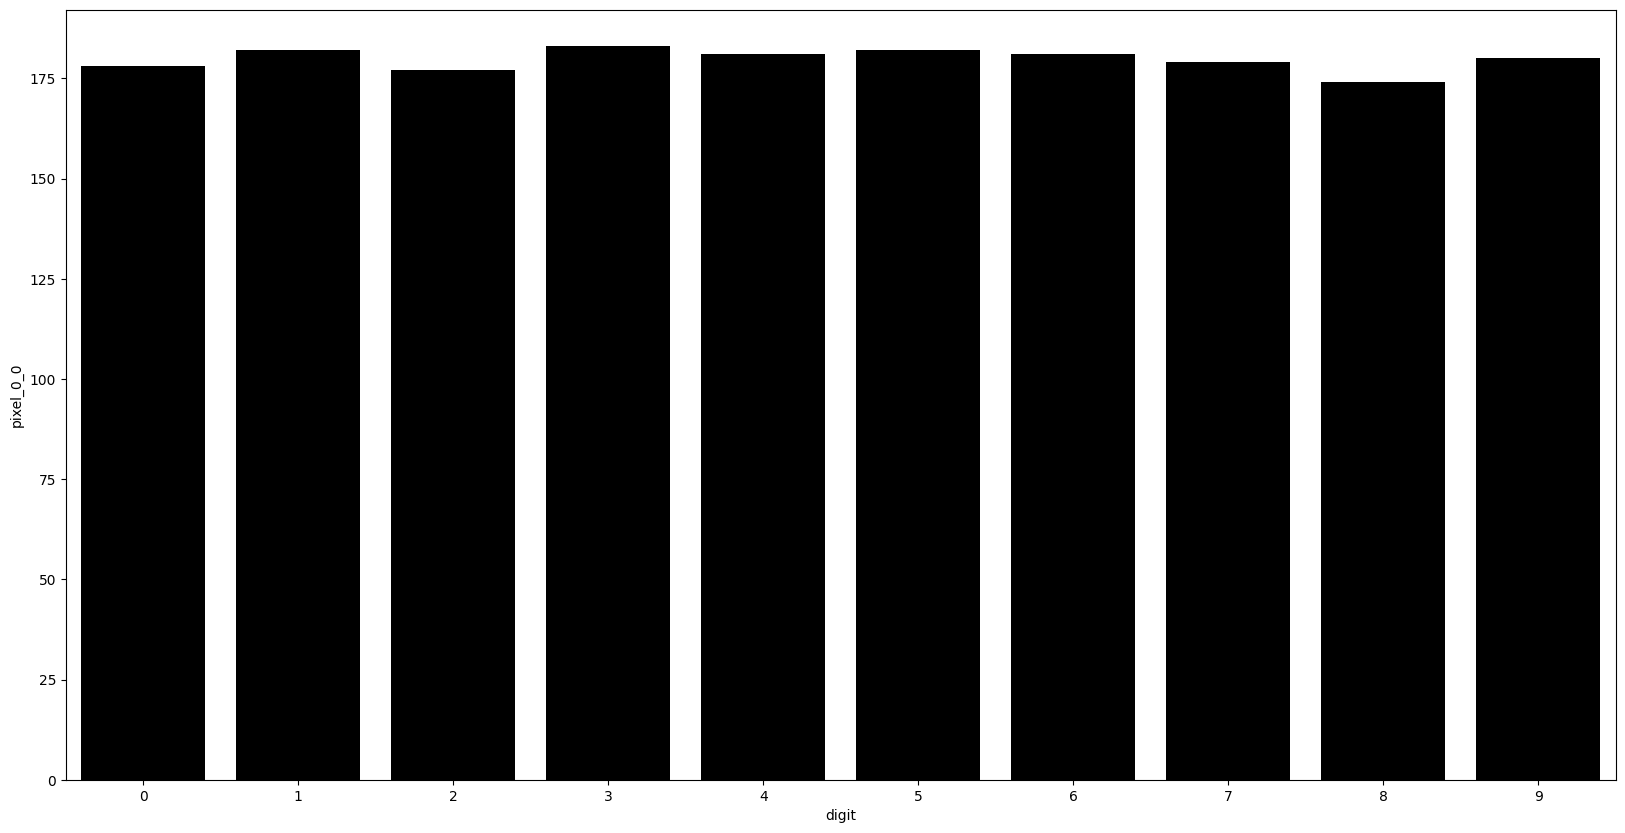

In [9]:
## Exploring the class distribution for the digits
counts = data[['pixel_0_0','digit']].groupby(by=['digit']).count()
counts = counts.reset_index()

plt.figure(figsize=(20,10))
sns.barplot(counts,x='digit',y='pixel_0_0', color='Black')

plt.show()

No class imbalances in the datasets. All digits have observations between 170 and 180.

Text(0.5, 1.0, 'Feature Correlation Matrix')

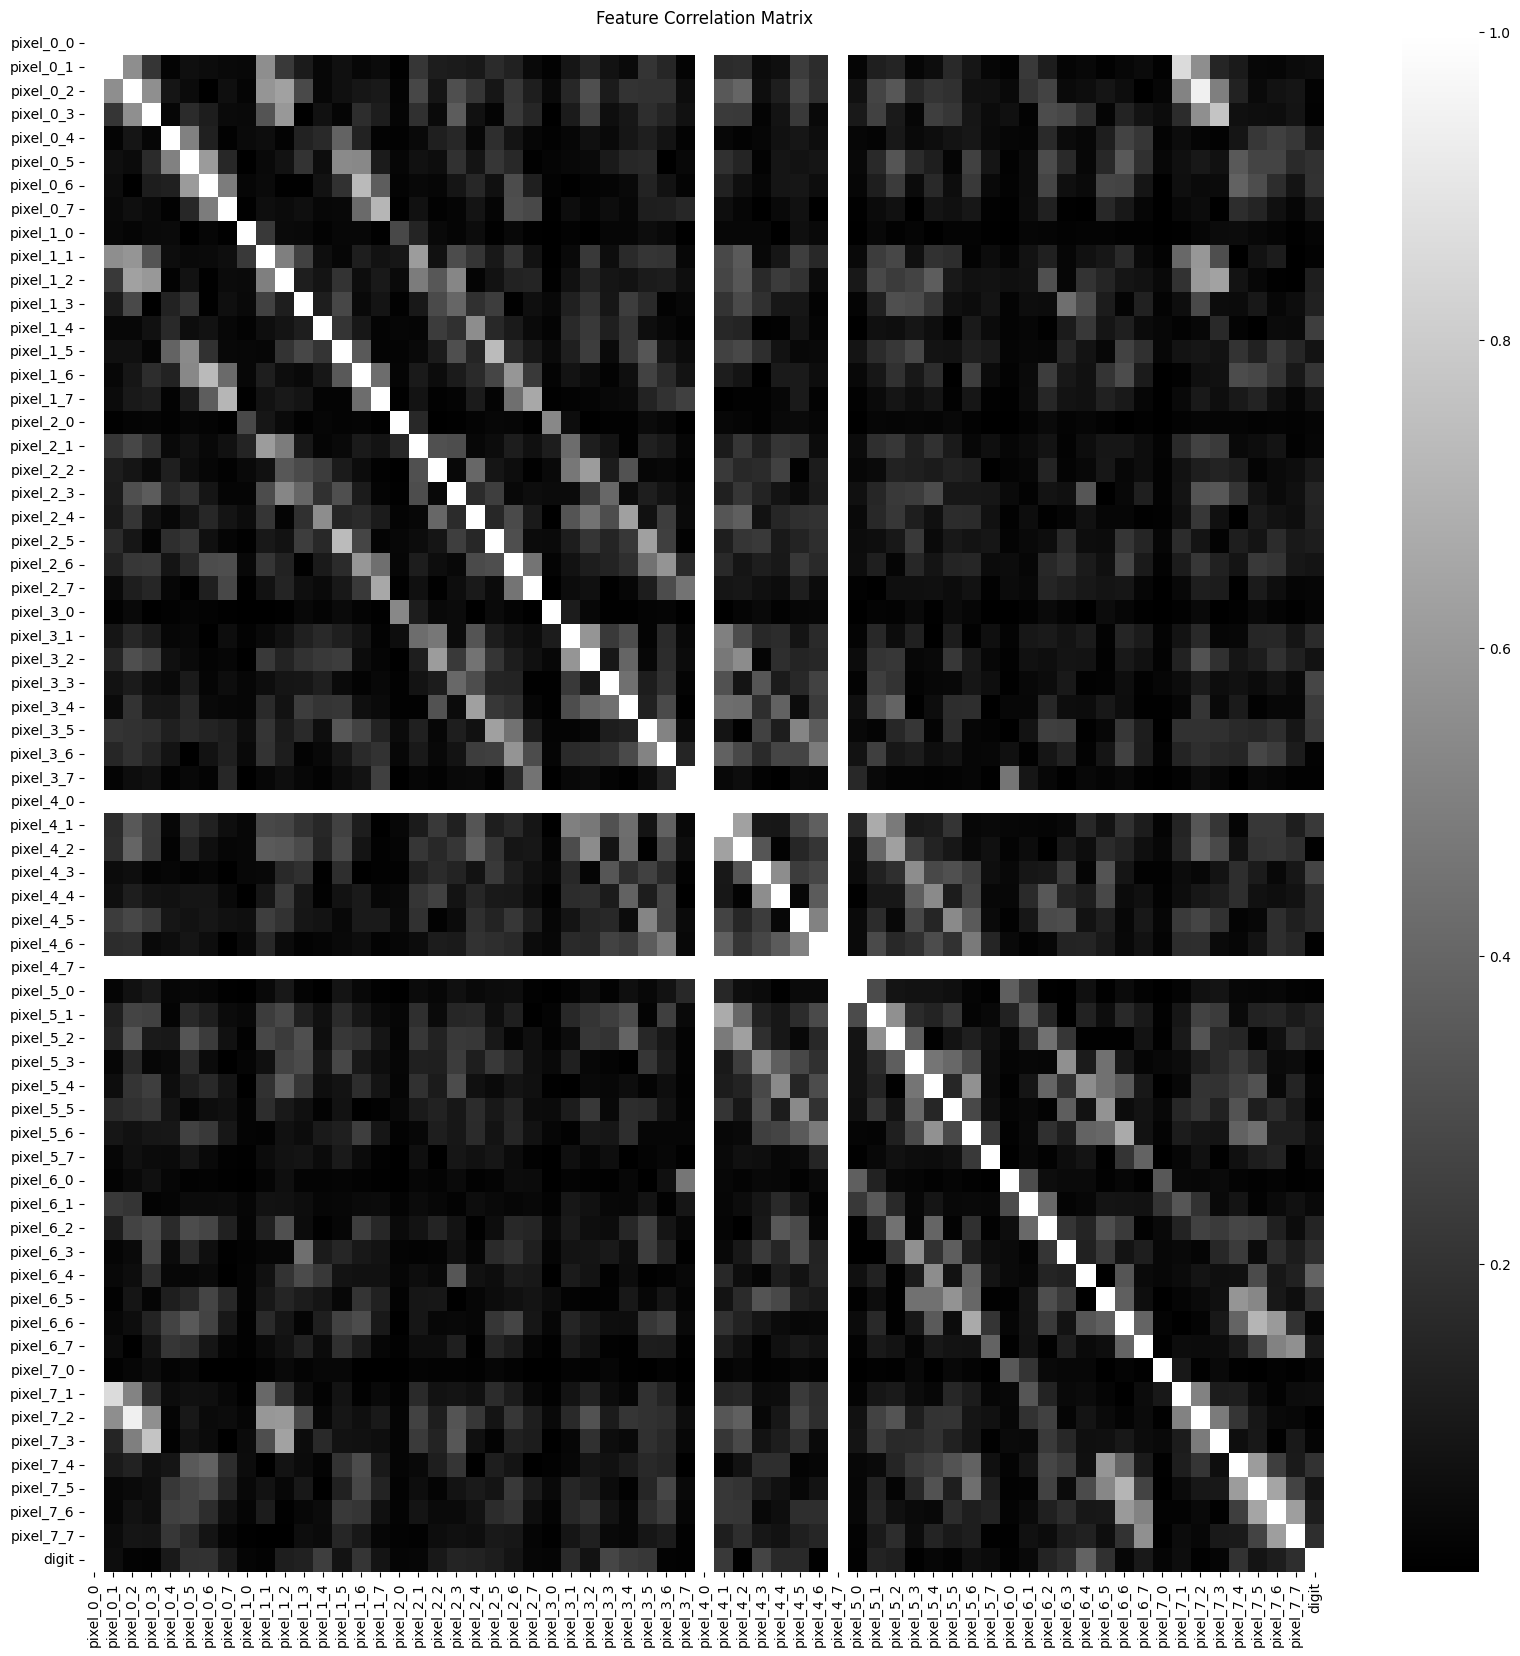

In [10]:
## Exploring correlation between features
plt.figure(figsize=(20,20))
sns.heatmap(data.corr().abs(), cmap='gray')
plt.title('Feature Correlation Matrix')

It seems like `pixel_4_0` and `pixel_4_7` are constant values as they correlate with all features. Since these are pixels on the edges, there could be no information on these features hence we should consider dropping the features.

In [11]:
## Let's look at pixel_4_0_ and pixel_4_7_
data[['pixel_4_0','pixel_4_7']].describe()

,pixel_4_0,pixel_4_7
count,1797.0,1797.0
mean,0.0,0.0
std,0.0,0.0
min,0.0,0.0
25%,0.0,0.0
50%,0.0,0.0
75%,0.0,0.0
max,0.0,0.0


We can now affirm that `pixel_4_0` and `pixel_4_7` are constant at `0`. We'll drop these columns.

In [12]:
data = data.drop(['pixel_4_0','pixel_4_7'], axis=1)
data.shape

(1797, 63)

## Machine Learning Modeling

In [21]:
X = data.drop(['digit'], axis=1)
X_scaled = StandardScaler().fit_transform(X) ##Standardise the features
y = data.digit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1078, 62) (719, 62) (1078,) (719,)


**Note:** For the purposes of showing how we conduct error analysis, I decided to reduce the train set significantly as with more data, I get close to 100% accuracy (only one error to examine). However, for your personal projects, this is not a constraint you need to add, use 10%, 20% as your test set so that you have enough data to deduce the feature relationships with your target variable. At times if you have a million observations, even 10,000 entries (1%) could be enough for testing.

### Basic Modeling
Let's try different models to understand which type of model work best for the data. We'll try optimise the hyperparameters manually to get to the closest optimal performance for each model tried.

#### K Nearest Neighbours (Base Model)

In [22]:
knn = KNeighborsClassifier(n_neighbors=1, weights='uniform', p=2)
cross_val_score(knn,X_train,y_train,cv=5,scoring='accuracy').mean()

0.9879457364341085

#### Logistic Regression (Linear Model)

In [15]:
logit = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression(C=1,penalty='l2', max_iter=1000))
cross_val_score(logit,X_train,y_train,cv=5,scoring='accuracy').mean()

0.9823815676141259

Note that gradient descent doesn't converge with 100 maximum iterations, we need to adjust this figure to fit the linear model.

#### Support Vector Machines

In [16]:
linearsvc = SVC(kernel='linear', C=5)
cross_val_score(linearsvc,X_train,y_train,cv=5,scoring='accuracy').mean()

0.9749526270456503

In [17]:
polysvc = SVC(kernel='poly', degree=2, C=5)
cross_val_score(polysvc,X_train,y_train,cv=5,scoring='accuracy').mean()

0.9860809646856158

In [18]:
rbfsvc = SVC(kernel='rbf', C=5)
cross_val_score(rbfsvc,X_train,y_train,cv=5,scoring='accuracy').mean()

0.9879371231696814

#### Ensemble Methods

In [46]:
## Try random forests, bagging, boosting to see if they are better performing models
## Manually try the hyperparameters that add bias or variance to avoid overfitting and underfitting respectiviely

### Hyperparameter Tuning
KNN and Support Vectors with RBF kernel were the best performing models. Let's run more in-depth hyperparameter tuning on these models to find the optimal model for our data.

In [20]:
model = KNeighborsClassifier()
parameters = {'n_neighbors':[1,3,6,9,12,15,18,21,24,27,30],'weights':('uniform', 'distance'),'p':[1,2]}

clf = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
print(clf.best_score_, clf.best_params_)

0.9907192075796727 {'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}


In [23]:
model = SVC(kernel='rbf')
parameters = {'C':[2.25,2.5,2.75,3,3.25,3.5,3.75,4]}

clf = GridSearchCV(model, parameters, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)
print(clf.best_score_, clf.best_params_)

0.9898018949181739 {'C': 2.5}


SVC with RBF kernel performs better than KNN. Let's focus on this model to further evaluate the model performance.

### Model Evaluation

In [33]:
### Let's fit the model with optimal hyperparameters to the full training set
final_model = SVC(kernel='rbf', C=2.5).fit(X_train,y_train)
y_pred = final_model.predict(X_test)
print(accuracy_score(y_pred, y_test)) ## Test set accuracy

0.9874826147426982


In [34]:
y_train_pred = final_model.predict(X_train)
print(accuracy_score(y_train_pred, y_train)) ## Train set accuracy

0.9981447124304267


#### Bias-Variance Analysis
After the final model, we deduce the following:
| Train vs Test Set | Accuracy Score | Error | Notes |
|---|---|---|---|
| Training Data | 99.81% | 0.19% |
| Testing Data | 98.75% | 1.25% |
| Human Prediction | ~99.5% | ~0.50% | Assumed optimal performance |

There is a very small gap between training accuracy and testing accuracy. However, 99.81% training accuracy suggests that the model could be slightly overfitting the data. 

**Assumption:** The 99.81% training is likely to be better than the accuracy of a human who is more times than not going to make one error or two. Our assumed optimal accuracy is 99.5%  though this could be investigated by giving humans the same classification task.

**Question:** How can we reduce the slight overfitting on train set to make the model more generalisable and thus increase the testing accuracy from 98.81% and closer to 99.5%? Let's investigate where the errors occur predominantly.

### Error Analysis

#### Confusion Matrix

<Figure size 2000x1000 with 0 Axes>

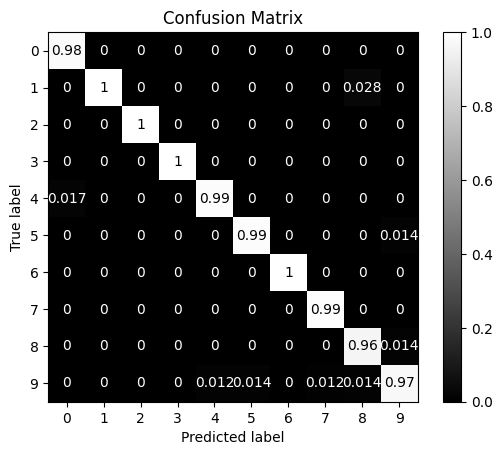

In [43]:
### Create a confusion matrix for the data
plt.figure(figsize=(20,10))
cm = confusion_matrix(y_pred,y_test, normalize='pred',labels=final_model.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_).plot(cmap='gray')

plt.title('Confusion Matrix')
plt.show()

From the Confusion Matrix, we can see that errors are more common in certain classes than others. Let's investigate this below.

#### Consolidated evaluation data

In [36]:
### Combine data on features with the model predictions
eval_data = pd.DataFrame(X_test, columns=data.columns[:-1])
eval_data['y_true'] = y_test
eval_data['y_pred'] = y_pred
eval_data['error'] = y_pred != y_test ## Denote error as true if prediction is not equal to actual
eval_data.head(10)

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,y_true,y_pred,error
1427,0.0,3.0,16.0,15.0,1.0,0.0,0.0,0.0,0.0,10.0,...,2.0,14.0,15.0,11.0,8.0,3.0,0.0,2,2,False
1681,0.0,0.0,0.0,6.0,12.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,11.0,0.0,0.0,0.0,4,4,False
1617,0.0,0.0,5.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,...,0.0,3.0,15.0,15.0,1.0,0.0,0.0,5,5,False
8,0.0,0.0,9.0,14.0,8.0,1.0,0.0,0.0,0.0,0.0,...,0.0,11.0,16.0,15.0,11.0,1.0,0.0,8,8,False
1295,0.0,0.0,4.0,15.0,13.0,3.0,0.0,0.0,0.0,4.0,...,0.0,5.0,15.0,16.0,5.0,0.0,0.0,8,8,False
354,0.0,1.0,12.0,16.0,10.0,0.0,0.0,0.0,0.0,7.0,...,2.0,14.0,16.0,16.0,13.0,1.0,0.0,3,3,False
433,0.0,0.0,0.0,5.0,16.0,8.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,15.0,11.0,2.0,0.0,1,1,False
989,0.0,0.0,0.0,6.0,14.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,14.0,16.0,13.0,0.0,6,6,False
1001,0.0,0.0,0.0,1.0,15.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,16.0,5.0,0.0,0.0,4,4,False
52,0.0,0.0,3.0,12.0,16.0,16.0,6.0,0.0,0.0,0.0,...,0.0,4.0,16.0,5.0,0.0,0.0,0.0,7,7,False


#### Error frequency per class

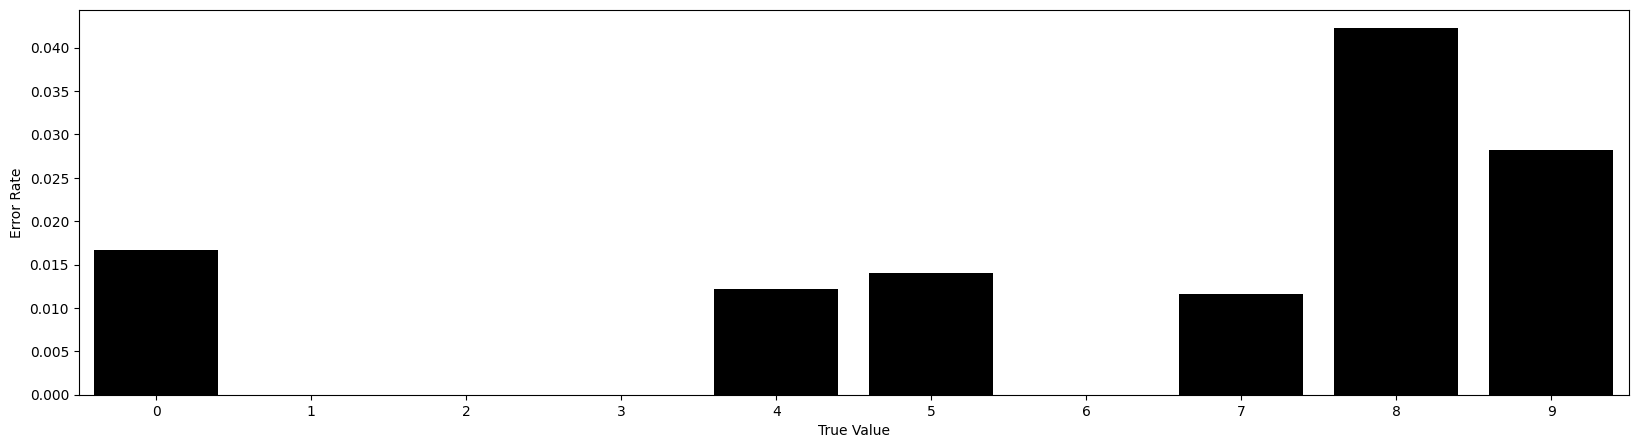

In [37]:
### Accuracy score based on the classes
accuracy = eval_data[['error','y_true']].groupby(by=['y_true']).mean()
accuracy = accuracy.reset_index()

plt.figure(figsize=(20,5))
sns.barplot(accuracy,x='y_true',y='error',color='Black')

plt.ylabel('Error Rate')
plt.xlabel('True Value')
plt.show()

Errors are most common in digits 8 and 9, followed by digit 0, 4, 5 and 7. No errors in digit 0, 1, 2, 3 and 6.
Let's visualise these errors to understand what could be causing the issue.

#### Visualising errors made in error-prone classes

In [38]:
indices = [] ## Index of the images with errors
pred_values = [] 
true_values = []

for i in [8,9,0,4,5,7]: ## Focus on numbers prone to errors
    err = eval_data[eval_data.y_true == i][eval_data.error == True]
    indices = indices + list(err.index) ##Append indices with observations with errors
    pred_values = pred_values + list(err.y_pred) ##Append the predicted value of the observation with errors
    true_values = true_values + list(err.y_true) ###Append the true value of the observation with errors

print(indices,pred_values, true_values)
print('Image count:', len(indices))

[1571, 794, 1553, 37, 547, 1573, 1575, 480] [9, 1, 1, 5, 8, 4, 9, 9] [8, 8, 8, 9, 9, 0, 5, 7]
Image count: 8


/var/folders/35/13d00tc92bb7m81x0w1lfh5r0000gn/T/ipykernel_48047/696343100.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err = eval_data[eval_data.y_true == i][eval_data.error == True]
/var/folders/35/13d00tc92bb7m81x0w1lfh5r0000gn/T/ipykernel_48047/696343100.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err = eval_data[eval_data.y_true == i][eval_data.error == True]
/var/folders/35/13d00tc92bb7m81x0w1lfh5r0000gn/T/ipykernel_48047/696343100.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err = eval_data[eval_data.y_true == i][eval_data.error == True]
/var/folders/35/13d00tc92bb7m81x0w1lfh5r0000gn/T/ipykernel_48047/696343100.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  err = eval_data[eval_data.y_true == i][eval_data.error == True]
/var/folders/35/13d00tc92bb7m81x0w1lfh5r0000gn/T/ipykernel_48047/696343100.py:6: UserWarning: Boolean Series

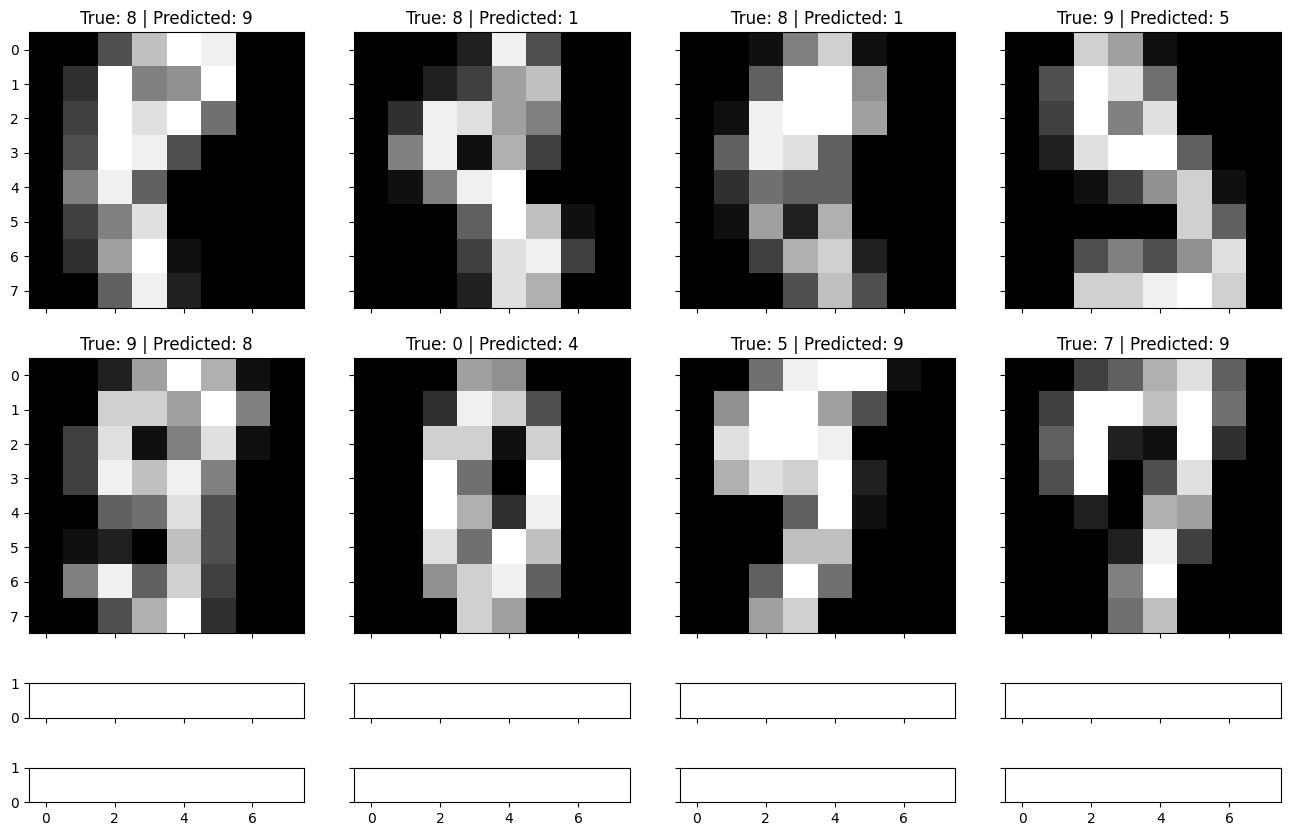

In [39]:
fig = plt.figure(figsize=(20, 10))
grid = ImageGrid(fig, 111,  nrows_ncols=(4,4), axes_pad=0.5)

for ax, index, pred_label, true_label in zip(grid, indices, pred_values, true_values):
    ax.imshow(images[index], cmap='gray')
    ax.set_title(f'True: {true_label} | Predicted: {pred_label}')


From the error visualisation above, we can see:
| True Value | Predicted Value | Frequency |
|---|---|---|
| 8 | 1 | 2 |
| 8 | 9 | 1 |
| 9 | 5 | 1 |
| 9 | 8 | 1 |
| 5 | 9 | 1 |
| 5 | 9 | 1 |

From a general overview of the errors, half of the errors would not be made by a human, but the remaining half are hard to categorise and is no surprise why the model misclassified them.

The most common error is predicting 8 as 1. This happens mostly when the image doesn't have the two black pixels within the white pixels as is expected for an 8. From the visualisations, a human would also struggle to denote this error. Here is what we should prioritise:
- More data on the misclassified samples would create a better model (Hopefully eleiminate the errors detectable by eye)
- In case of limited data, we should consider our preprocessing approach to make the images more clear (increase the number of pixels)

The count of errors is too small to investigate the correlation between the errors and features, thus, we'll focus on the two recommendations above for our next modeling approach.